In [1]:
# Notebook to try ssim and sam on the images

import os
import hydra
import numpy as np
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import save_image
from torchvision import transforms as T
from PIL import Image
# from agent.encoder import Encoder

from tactile_learning.models import *
from tactile_learning.utils import *
from tactile_learning.tactile_data import *


In [2]:
def load_one_episode(fn):
    with open(fn, 'rb') as f:
        episode = np.load(f)
        episode = {k: episode[k] for k in episode.keys()}
    return episode

def load_root_episodes(root_path):
    episodes = []
    print()
    fns = sorted(glob.glob(f'{root_path}/*.npz'))
    # print('fns: {}'.format(fns))
    for i,fn in enumerate(fns):
        episode = load_one_episode(fn)
        episodes.append(episode)

    return episodes

def load_all_episodes(root_path = None, roots = None):
    if roots is None:
        roots = glob.glob(f'{root_path}/*')
    all_episodes = []
    for root in roots:
        root_episodes = load_root_episodes(root)
        all_episodes += root_episodes

    return all_episodes

In [3]:
# Get the SSIM module
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# Load the episodes and the experts
# This image transform will have the totensor and normalization only
def load_episode_demos(all_episodes, image_transform=None):
    episode_demos = []
    for episode in all_episodes:
        transformed_image_obs = []
        # tactile_reprs = []
        for image_obs in episode['pixels']:
            # pil_image = Image.fromarray(np.transpose(image_obs, (1,2,0)), 'RGB')
            # print('pil_image.shape: {}'.format(pil_image.shape))
            if not image_transform is None:
                transformed_image_obs.append(
                    image_transform(image_obs / 255.)
                )  
            else: 
                transformed_image_obs.append(
                    torch.FloatTensor(image_obs / 255.)
                )
        episode_demos.append(dict(
            image_obs = torch.stack(transformed_image_obs, 0),
            tactile_repr = torch.FloatTensor(episode['tactile'])
        ))

    return episode_demos

# This image transform will have everything
def load_expert_demos(data_path, expert_demo_nums, tactile_repr_module, image_transform, view_num):
    roots = sorted(glob.glob(f'{data_path}/demonstration_*'))
    data = load_data(roots, demos_to_use=expert_demo_nums)
    
    expert_demos = []
    image_obs = [] 
    tactile_reprs = []
    old_demo_id = -1
    for step_id in range(len(data['image']['indices'])): 
        demo_id, tactile_id = data['tactile']['indices'][step_id]
        if (demo_id != old_demo_id and step_id > 0) or (step_id == len(data['image']['indices'])-1): # NOTE: We are losing the last frame of the last expert

            expert_demos.append(dict(
                image_obs = torch.stack(image_obs, 0), 
                tactile_repr = torch.stack(tactile_reprs, 0)
            ))
            image_obs = [] 
            tactile_reprs = []

        tactile_value = data['tactile']['values'][demo_id][tactile_id]
        tactile_repr = tactile_repr_module.get(tactile_value, detach=False)

        _, image_id = data['image']['indices'][step_id]
        image = load_dataset_image(
            data_path = data_path, 
            demo_id = demo_id, 
            image_id = image_id,
            view_num = view_num,
            transform = image_transform
        )
        image_obs.append(torch.FloatTensor(image))
        tactile_reprs.append(tactile_repr)


        old_demo_id = demo_id

    return expert_demos


In [4]:
def get_all_demos(cfg: DictConfig):
    # cfg = cfg.plot_all_rewards
    device = torch.device(cfg.device)
    tactile_cfg, tactile_encoder, _ = init_encoder_info(device, cfg.tactile_out_dir, 'tactile', model_type='byol')
    tactile_img = TactileImage(
        tactile_image_size = tactile_cfg.tactile_image_size, 
        shuffle_type = None
    )
    tactile_repr_module = TactileRepresentation( # This will be used when calculating the reward - not getting the observations
        encoder_out_dim = tactile_cfg.encoder.out_dim,
        tactile_encoder = tactile_encoder,
        tactile_image = tactile_img,
        representation_type = 'tdex',
        device = device
    )

    def viewed_crop_transform(image):
        return crop_transform(image, camera_view=cfg.view_num)
    expert_demos = load_expert_demos(
        data_path = cfg.data_path,
        expert_demo_nums=cfg.expert_demo_nums,
        tactile_repr_module=tactile_repr_module,
        image_transform = T.Compose([
            T.Resize((480,640)),
            T.Lambda(viewed_crop_transform),
            T.Resize(480),
            T.ToTensor(),
        ]),
        view_num = cfg.view_num
    )

    all_episodes = load_all_episodes(
        roots = cfg.episode_roots, # Either one of them will be none
        root_path = cfg.episode_root_path
    )
    episode_demos = load_episode_demos(
        all_episodes= all_episodes,
    )

    return expert_demos, episode_demos

In [5]:
# Plot simm differences with the end frames of the episodes
cfg = OmegaConf.load('/home/irmak/Workspace/tactile-learning/tactile_learning/configs/debug.yaml')
cfg = cfg.plot_all_rewards
expert_demos, episode_demos = get_all_demos(cfg)



Using cache found in /home/irmak/.cache/torch/hub/pytorch_vision_v0.10.0
/home/irmak/miniconda3/envs/tactile_learning/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/irmak/miniconda3/envs/tactile_learning/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


mod_name: collections, name: OrderedDict
mod_name: torch._utils, name: _rebuild_parameter
mod_name: torch._utils, name: _rebuild_tensor_v2



In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

mod_name: torch._utils, name: _rebuild_tensor_v2
mod_name: collections, name: OrderedDict


In [7]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

    return img

In [8]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])



In [9]:
def get_ssim(img1, img2, apply_sam):
    channel_axis = 2
    if apply_sam:
        masks = mask_generator.generate((img1 * 255).astype(np.uint8))
        img1 = rgb2gray(show_anns(masks)*255)

        masks = mask_generator.generate((img2*255).astype(np.uint8))
        img2 = rgb2gray(show_anns(masks)*255)

        channel_axis = None

    reward = ssim(
        img1,
        img2,
        data_range=max(img1.max(), img2.max()) - min(img1.min(), img2.min()),
        channel_axis=channel_axis
    )
    return reward

In [14]:
def get_ssims_for_expert(expert_demos, episode_demos, expert_id, apply_sam=False, matrix=False):
    rewards = []
    for episode_id in range(len(episode_demos)):
        if matrix: # Traverse through each trajectory 
            ssim_matrix = np.zeros((len(episode_demos[episode_id]['image_obs']), len(expert_demos[expert_id]['image_obs'])))
            for ep_traj_id in range(len(episode_demos[episode_id]['image_obs'])):
                episode_img = np.transpose(episode_demos[episode_id]['image_obs'][ep_traj_id].numpy(), (1,2,0))
                for ex_traj_id in range(len(expert_demos[expert_id]['image_obs'])):
                    expert_img = np.transpose(expert_demos[expert_id]['image_obs'][ex_traj_id].numpy(), (1,2,0))
        
                    curr_ssim = get_ssim(episode_img, expert_img, apply_sam)
                    ssim_matrix[ep_traj_id, ex_traj_id] = curr_ssim

            rewards.append(ssim_matrix)

        else: # Just get the last frame of the trajectories
            episode_img = np.transpose(episode_demos[episode_id]['image_obs'][-1].numpy(), (1,2,0))
            expert_img = np.transpose(expert_demos[expert_id]['image_obs'][-1].numpy(), (1,2,0))
            curr_ssim = get_ssim(episode_img, expert_img, apply_sam)

            rewards.append(curr_ssim)

    rewards = np.stack(rewards, 0)

    return rewards

In [15]:
all_ssims = get_ssims_for_expert(
    expert_demos, 
    episode_demos, 
    0,
    apply_sam = False,
    matrix = True
)

In [20]:
all_ssims_cropped = all_ssims[:,:,:len(expert_demos[0]['image_obs'])]

In [21]:
print(all_ssims_cropped.shape)

(35, 50, 48)


(35, 50, 50)


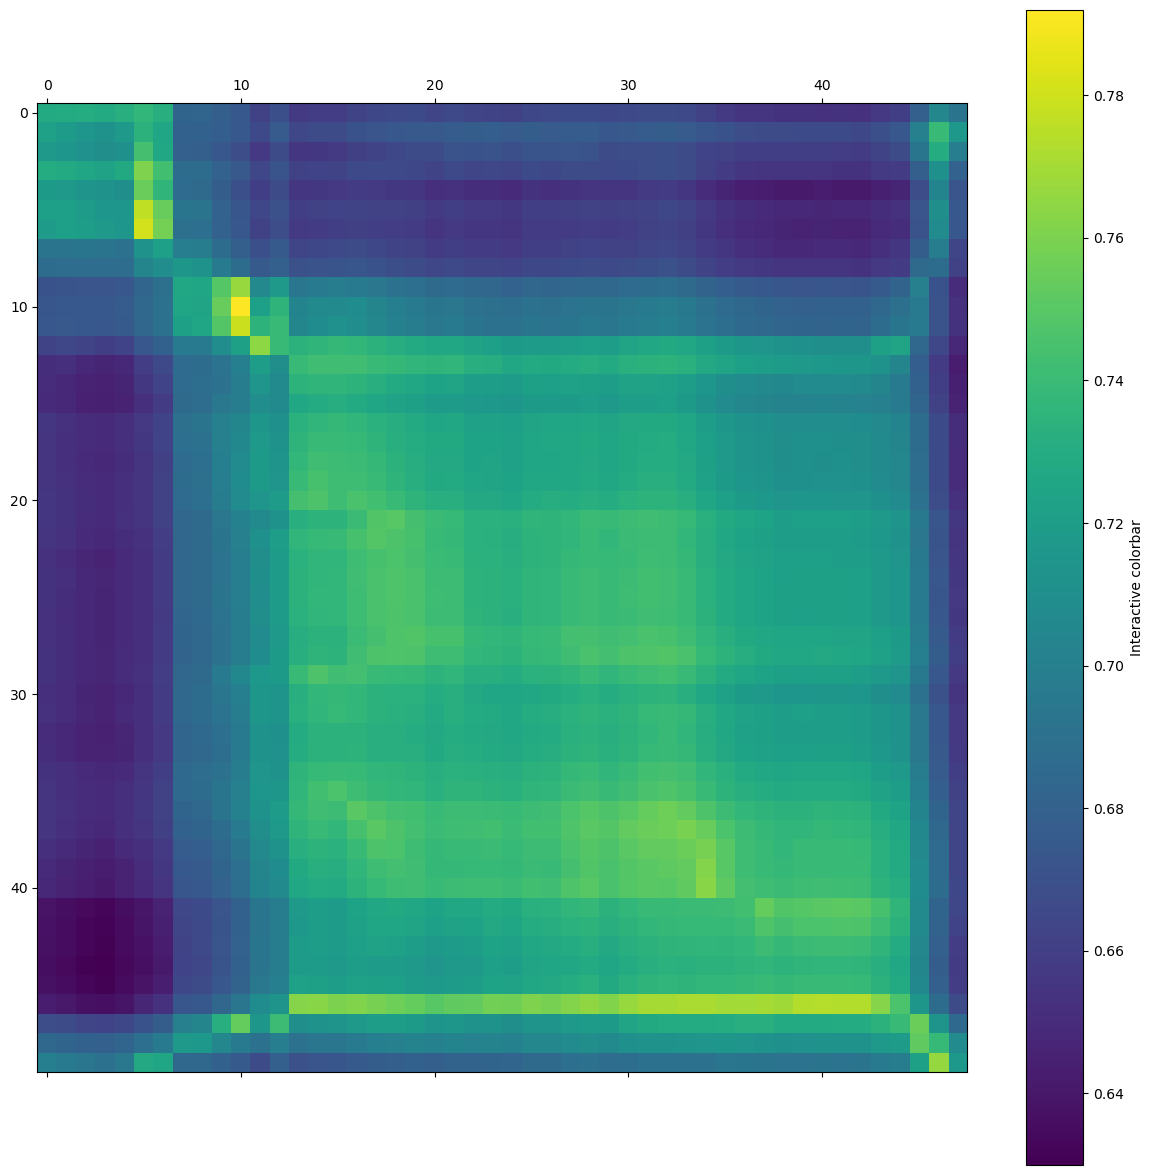

In [22]:

print(all_ssims.shape)

# Plot one of cost matrices
cost_matrix = all_ssims_cropped[20]
fig, ax = plt.subplots(figsize=(15,15),nrows=1,ncols=1)
im = ax.matshow(cost_matrix)
fig.colorbar(im, ax=ax, label='Interactive colorbar')


In [17]:
def prep_demos_for_visualization(episode_demos, expert_demos, sort=False, rewards=None, apply_sam=False):
    expert_frames = []
    episode_frames = []

    if sort:
        sorted_reward_ids = np.argsort(rewards)
    else:
        sorted_reward_ids = range(len(rewards))

    for episode_id in sorted_reward_ids:
        episode_img = np.transpose(episode_demos[episode_id]['image_obs'][-1].numpy(), (1,2,0))
        if apply_sam:
            episode_masks = mask_generator.generate((episode_img*255).astype(np.uint8))
            episode_img = rgb2gray(show_anns(episode_masks)*255)
        episode_frames.append(episode_img)
    
    for expert_id in range(len(expert_demos)):
        expert_img = np.transpose(expert_demos[expert_id]['image_obs'][-1].numpy(), (1,2,0))
        if apply_sam:
            expert_masks = mask_generator.generate((expert_img*255).astype(np.uint8))
            expert_img = rgb2gray(show_anns(expert_masks)*255)
        expert_frames.append(expert_img)

    return expert_frames, episode_frames, sorted_reward_ids

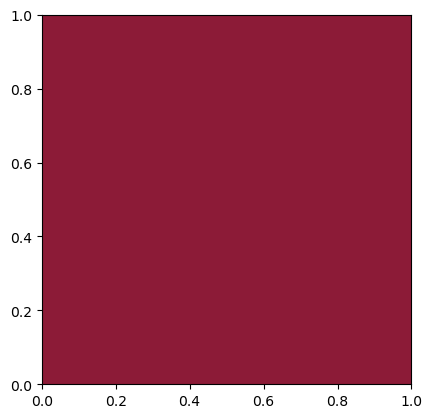

In [18]:
expert_frames, episode_frames, sorted_reward_ids = prep_demos_for_visualization(
    episode_demos = episode_demos, 
    expert_demos = expert_demos,
    sort = True,
    rewards = rewards,
    apply_sam = True, # It will apply grayscale sam on the images for the frames
)

In [19]:
# This class will plot the last frame of the episodes
# the given best expert id's last frame
# and write the reward given to that
class RewardPlotter:
    def __init__(
        self, 
        episode_frames,
        expert_frames,
        expert_ids,
        rewards,
    ):
        self.episode_frames = episode_frames 
        self.expert_frames = expert_frames 
        self.expert_ids = expert_ids 
        self.rewards = rewards

    def plot_rewards(self, nrows, ncols, figure_name, grayscale=False):
        figsize = ((ncols*2)*5, nrows*5) # there will be two images for each column 
        fig, axs = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols*2)
        fig.suptitle('All rewards for all episodes')

        # Plot the episodes 
        pbar = tqdm(total=nrows*ncols)
        for row in range(nrows):
            for col in range(ncols):
                if col*nrows+row > len(self.episode_frames)-1:
                    break
                
                # Plot the episodes
                if grayscale:
                    axs[row][col*2].imshow(self.episode_frames[col*nrows+row], cmap='gray', vmin=0, vmax=255)
                else:
                    axs[row][col*2].imshow(self.episode_frames[col*nrows+row])
                
                # Plot the experts 
                if grayscale:
                    axs[row][col*2+1].imshow(self.expert_frames[self.expert_ids[col*nrows+row]], cmap='gray', vmin=0, vmax=255)
                else:
                    axs[row][col*2+1].imshow(self.expert_frames[self.expert_ids[col*nrows+row]])
                
                # Print the rewards
                axs[row][col*2+1].set_xlabel(f'REWARD: {self.rewards[col*nrows+row]}')
                axs[row][col*2+1].set_title(f'EXPERT ID: {self.expert_ids[col*nrows+row]}')
                pbar.update(1)
                pbar.set_description('row: {}, col*2+1: {}, ccol*nrows+row: {}'.format(
                    row, col*2+1, col*nrows+row
                ))
                print('row: {}, col*2+1: {}, col*nrows+row: {}'.format(
                    row, col*2+1, col*nrows+row
                ))

        pbar.close()
        plt.savefig(figure_name, bbox_inches='tight')
        # plt.show()

ncols: 1, nrows: 35
episode_ts: 20230530T21-04


row: 34, col*2+1: 1, ccol*nrows+row: 34: 100%|██████████| 35/35 [00:00<00:00, 585.53it/s]


row: 0, col*2+1: 1, col*nrows+row: 0
row: 1, col*2+1: 1, col*nrows+row: 1
row: 2, col*2+1: 1, col*nrows+row: 2
row: 3, col*2+1: 1, col*nrows+row: 3
row: 4, col*2+1: 1, col*nrows+row: 4
row: 5, col*2+1: 1, col*nrows+row: 5
row: 6, col*2+1: 1, col*nrows+row: 6
row: 7, col*2+1: 1, col*nrows+row: 7
row: 8, col*2+1: 1, col*nrows+row: 8
row: 9, col*2+1: 1, col*nrows+row: 9
row: 10, col*2+1: 1, col*nrows+row: 10
row: 11, col*2+1: 1, col*nrows+row: 11
row: 12, col*2+1: 1, col*nrows+row: 12
row: 13, col*2+1: 1, col*nrows+row: 13
row: 14, col*2+1: 1, col*nrows+row: 14
row: 15, col*2+1: 1, col*nrows+row: 15
row: 16, col*2+1: 1, col*nrows+row: 16
row: 17, col*2+1: 1, col*nrows+row: 17
row: 18, col*2+1: 1, col*nrows+row: 18
row: 19, col*2+1: 1, col*nrows+row: 19
row: 20, col*2+1: 1, col*nrows+row: 20
row: 21, col*2+1: 1, col*nrows+row: 21
row: 22, col*2+1: 1, col*nrows+row: 22
row: 23, col*2+1: 1, col*nrows+row: 23
row: 24, col*2+1: 1, col*nrows+row: 24
row: 25, col*2+1: 1, col*nrows+row: 25
row: 2

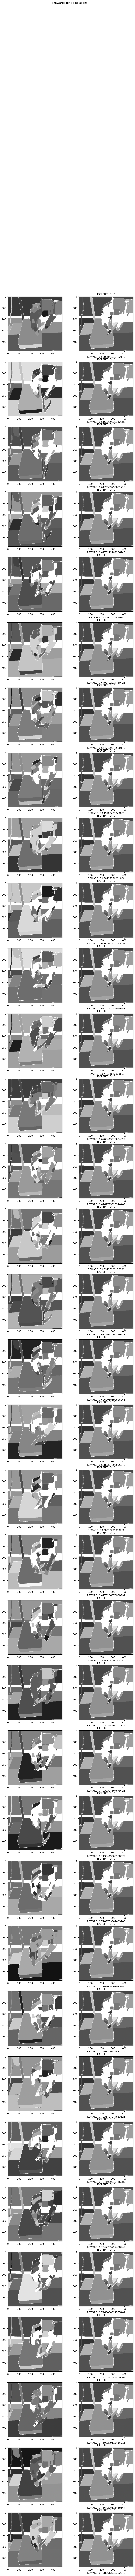

In [22]:
sorted_expert_ids = [0 for _ in sorted_reward_ids]
sorted_rewards = [rewards[reward_id] for reward_id in sorted_reward_ids]
plotter = RewardPlotter(
    episode_frames = episode_frames,
    expert_frames = expert_frames, 
    expert_ids = sorted_expert_ids,
    rewards = sorted_rewards
) 
ncols = 1
# nrows = min(int(len(episode_frames)/ncols), 60)
nrows = int(len(episode_frames)/ncols)
print('ncols: {}, nrows: {}'.format(ncols, nrows))
episode_time_step = cfg.episode_roots[0].split('/')[-1].split('_')[0]
# Remove the dots from the string
ts_arr = episode_time_step.split('.')
episode_ts = ''.join(ts_arr)
print('episode_ts: {}'.format(episode_ts))
plotter.plot_rewards(
    nrows = nrows,
    ncols = ncols,
    figure_name = f'sam_applied_{cfg.object}_{episode_ts}_ssim',
    grayscale=True
)

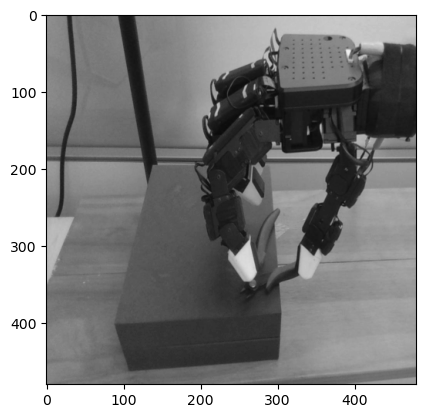

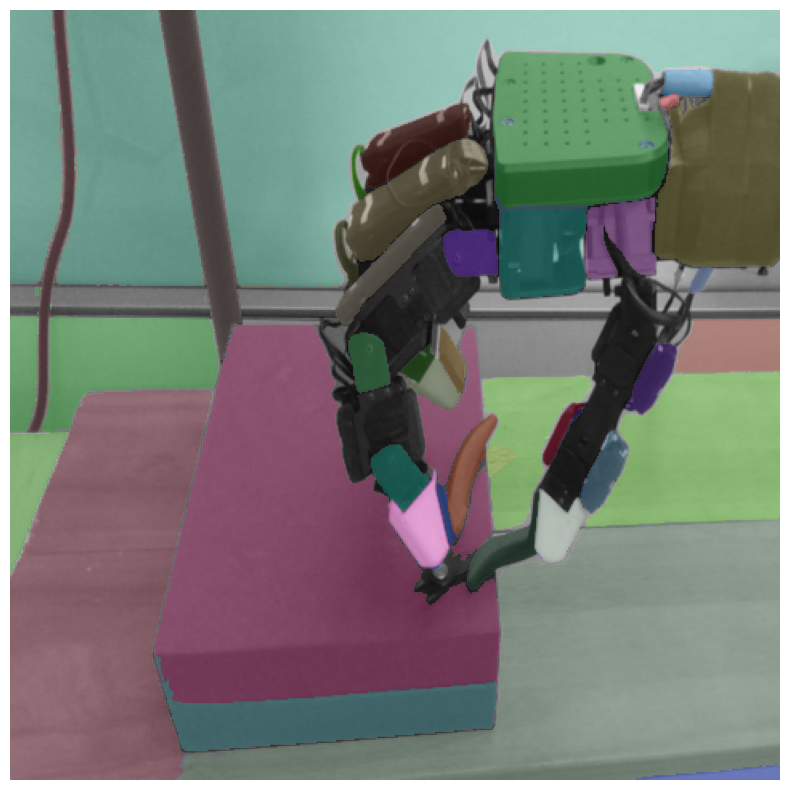

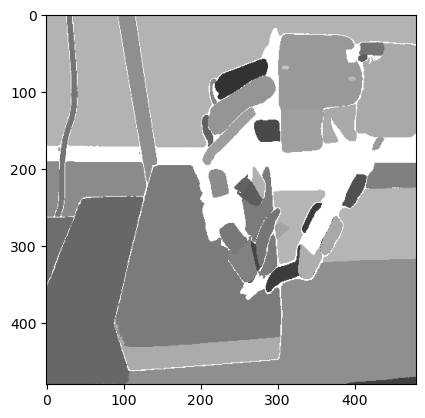

In [33]:
ep_id = 16
episode_img = (episode_frames[ep_id].numpy() * 255).astype(np.uint8)
episode_img = rgb2gray(episode_img)
plt.imshow(episode_img, cmap='gray', vmin=0, vmax=255)
episode_img = np.expand_dims(episode_img, axis=2)
episode_img = np.repeat(episode_img, 3, axis=2).astype(np.uint8)
masks = mask_generator.generate(episode_img)
plt.figure(figsize=(10,10))
plt.imshow(episode_img)
masked_img = show_anns(masks)
plt.axis('off')
plt.show() 
grayscale_masked_img = rgb2gray(masked_img*255)
plt.imshow(grayscale_masked_img, cmap='gray', vmin=0, vmax=255)

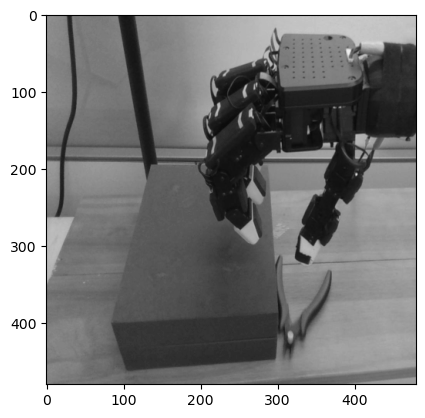

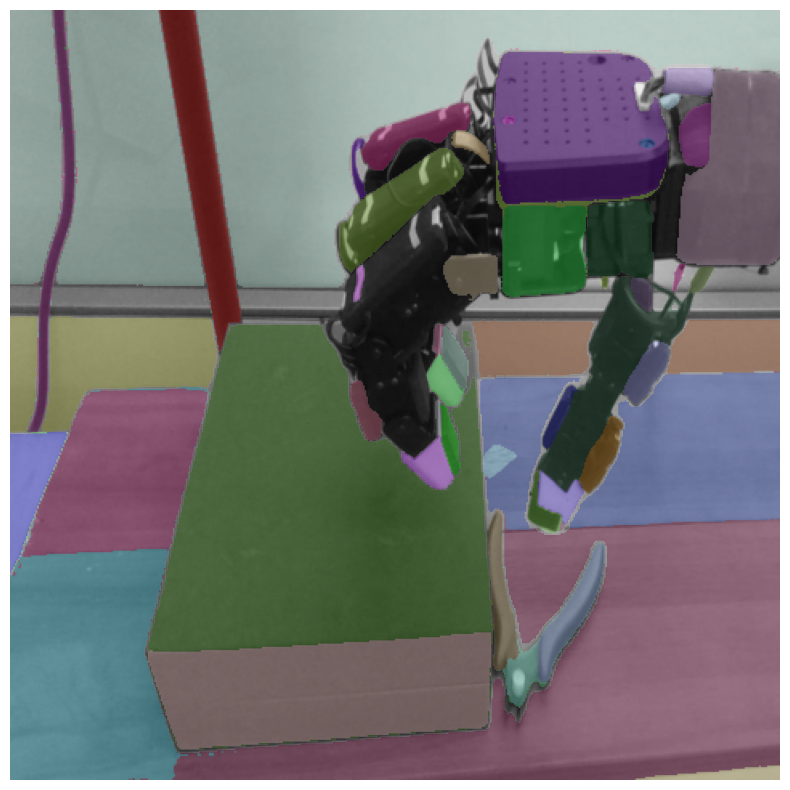

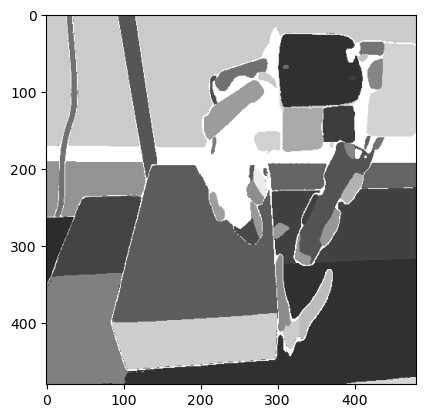

In [34]:
ep_id = 17
episode_img = (episode_frames[ep_id].numpy() * 255).astype(np.uint8)
episode_img = rgb2gray(episode_img)
plt.imshow(episode_img, cmap='gray', vmin=0, vmax=255)
episode_img = np.expand_dims(episode_img, axis=2)
episode_img = np.repeat(episode_img, 3, axis=2).astype(np.uint8)
masks = mask_generator.generate(episode_img)
plt.figure(figsize=(10,10))
plt.imshow(episode_img)
masked_img = show_anns(masks)
plt.axis('off')
plt.show() 
grayscale_masked_img = rgb2gray(masked_img*255)
plt.imshow(grayscale_masked_img, cmap='gray', vmin=0, vmax=255)